# Creating the datasets

In [81]:
import torch
from torch import nn
from torchvision.transforms import v2

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [82]:
import torch
from PIL import Image

import os

class CustomDataset(torch.utils.data.Dataset):
    """
    Custom dataset, loading image from disk so it is not necessary to load all images in memory
    """	
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if not os.path.exists(self.image_paths[idx]):
            raise FileNotFoundError(f"File {self.image_paths[idx]} not found")
            
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if image.size[1] > image.size[0]:
            image = image.rotate(90, Image.NEAREST, expand=1)
        image = self.transform(image)
        
        labels = self.labels[idx]

        if image.max() > 1:
            image = image / 255.0
        
        return image, int(labels)
        

## Patches dataset

In [83]:
import pathlib as pl
PATCH_PATH = pl.Path(os.path.abspath("")) / pl.Path('../data') / pl.Path('ndb_ufes') / pl.Path('patches')


In [120]:
class PatchDataset:
    name = 'patches_ndb'
    """
    Dataset for patches images. Arranges the patches in train and test sets considering the parent image (prefix of the image name). It has a train and test dataset that can be accessed by the attributes train_dataset and test_dataset.
    These datasets can be used in the DataLoader class from PyTorch.
    """	
    def __init__(self, path, train_size=0.8, k_folds=5, train_transform=None, test_transform=None):
        self.path = path
        self.k_folds = k_folds
        self.train_size = train_size
        
        self.train_transform = train_transform if train_transform is not None else v2.Compose([v2.ToTensor(),
                                                                                               v2.Resize((512,512)),
                                                                                               v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
        self.test_transform = test_transform if train_transform is not None else v2.Compose([v2.ToTensor(),
                                                                                             v2.Resize((512,512)),
                                                                                             v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        self.labels_names = {0: 'no_dysplasia', 1: 'carcinoma', 2: 'with_dysplasia'}
        self.train, self.test = self._train_test_split()

        self.train_dataset = CustomDataset(self.train[0], self.train[1], transform=self.train_transform)
        self.test_dataset = CustomDataset(self.test[0], self.test[1], transform=self.test_transform)

        self.folds_df = None
        self.k_folds_dataset = self._generate_k_folds()
    
    def _get_files(self):
        """
        Get files from the path by class carcinoma and non-carcinoma
        """
        # carcinoma images
        carcinoma = list(self.path.glob('carcinoma/*.png'))

        # non-carcinoma images
        no_dysplasia = list(self.path.glob('no_dysplasia/*.png'))
        with_dysplasia = list(self.path.glob('with_dysplasia/*.png'))

        return carcinoma, no_dysplasia, with_dysplasia
    
    def _get_parent_image_name(self, image_name):
        """
        Get the parent image name from the image name
        """
        image_filename = image_name.parts[-1]
        image_root = "_".join(image_filename.split('_')[0:-1])
        return image_root

    def _count_images_parent(self, image_class, image_parent):
        """
        This is a helper function to count the amount of images by parent image name
        """
        amount = {}
        for image in image_class:
            image_name = image.parts[-1]
            for parent in image_parent:
                if parent in image_name:
                    amount[parent] = amount.get(parent, 0) + 1
                    break

        return amount

    def _create_label_from_path(self, image_class):
        """
        Create the labels for the dataset
        """
        
        name = str(image_class)
        if 'carcinoma' in name:
            return 1
        elif 'no_dysplasia' in name:
            return 0
        elif 'with_dysplasia' in name:
            return 2

    def _train_test_split(self):
        """
        Split the dataset into train and test
        """
        carcinoma, no_dysplasia, with_dysplasia = self._get_files()
        carcinoma_parent = list(set([self._get_parent_image_name(image) for image in carcinoma]))
        no_dysplasia_parent = list(set([self._get_parent_image_name(image) for image in no_dysplasia]))
        with_dysplasia_parent = list(set([self._get_parent_image_name(image) for image in with_dysplasia]))

        images = list(set(carcinoma_parent).union(no_dysplasia_parent).union(with_dysplasia_parent))
        print(f"There are {len(images)} images in the dataset")
        print(f"There are {len(carcinoma_parent)} carcinoma images")
        print(f"There are {len(no_dysplasia_parent)} no dysplasia images")
        print(f"There are {len(with_dysplasia_parent)} with dysplasia images")
        print(f"Of these, intersection between carcinoma and no dysplasia: {len(set(carcinoma_parent).intersection(no_dysplasia_parent))}")
        print(f"Of these, intersection between carcinoma and with dysplasia: {len(set(carcinoma_parent).intersection(with_dysplasia_parent))}")
        print(f"Of these, intersection between no dysplasia and with dysplasia: {len(set(no_dysplasia_parent).intersection(with_dysplasia_parent))}")
        
        # create arrays of 1 and 0 for carcinoma and non-carcinoma
        carinoma_parents_len = len(set(carcinoma_parent))
        no_dysplasia_parents_len = len(set(no_dysplasia_parent).difference(carcinoma_parent))
        with_dysplasia_parents_len = len(set(with_dysplasia_parent).difference(carcinoma_parent).difference(no_dysplasia_parent))

        print(f"len of carcinoma parents: {carinoma_parents_len}")
        print(f"len of no dysplasia parents: {no_dysplasia_parents_len}")
        print(f"len of with dysplasia parents: {with_dysplasia_parents_len}")

        carcinoma_labels = list(np.ones(carinoma_parents_len))
        no_dysplasia_labels = list(np.zeros(no_dysplasia_parents_len))
        with_dysplasia_labels = list(np.ones(with_dysplasia_parents_len) * 2)

        labels = carcinoma_labels + no_dysplasia_labels + with_dysplasia_labels
        print(images)
        print(len(labels), len(images))

        # split the dataset by parent name
        images_train, images_test, labels_train, labels_test = train_test_split(images, labels, train_size=self.train_size, stratify=labels, random_state=42)
        
        # get patches images
        images_patches = carcinoma + no_dysplasia + with_dysplasia
        
        images_train = [image for image in images_patches if self._get_parent_image_name(image) in images_train]
        # 0, 1, 2 for no_dysplasia, carcinoma and with_dysplasia
        labels_train = [self._create_label_from_path(image) for image in images_train]

        images_test = [image for image in images_patches if self._get_parent_image_name(image) in images_test]
        labels_test = [self._create_label_from_path(image) for image in images_train]

        return (images_train, labels_train), (images_test, labels_test)
    
    def _create_df_splits(self, k_folds_datasets):
        """
        Create dataframe with the k-folds splits for the dataset
        """
        folds = [(i, fold) for i, fold in enumerate(k_folds_datasets)]
        folds = [(fold[0], fold[1][2], fold[1][3]) for fold in folds]

        # expand the folds
        folds = [(fold[0], image.parts[-1], label) for fold in folds for image, label in zip(fold[1], fold[2])]

        self.folds_df = pd.DataFrame(folds, columns=['fold', 'image_path', 'class'])


    def _generate_k_folds(self):
        """
        Generate k-folds for the dataset
        """
        
        images = self.train[0]
        images_parents = list(set([self._get_parent_image_name(image) for image in images]))

        folds = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)
        folds_parents_list = []

        for fold in folds.split(images_parents):
            train_index, test_index = fold
            train_parents = [images_parents[i] for i in train_index]
            test_parents = [images_parents[i] for i in test_index]

            train_imgs = [image for image in images if self._get_parent_image_name(image) in train_parents]
            test_imgs = [image for image in images if self._get_parent_image_name(image) in test_parents]

            train_labels = [self._create_label_from_path(image) for image in train_imgs]
            test_labels = [self._create_label_from_path(image) for image in test_imgs]

            folds_parents_list.append((train_imgs, train_labels, test_imgs, test_labels))

        self._create_df_splits(folds_parents_list)

        return folds_parents_list
    
    def get_k_fold_train_val_tuple(self, k):
        """
        Get K-fold train and validation dataset
        """
        train_dataset = CustomDataset(self.k_folds_dataset[k][0], self.k_folds_dataset[k][1], transform=self.train_transform)
        val_dataset = CustomDataset(self.k_folds_dataset[k][2], self.k_folds_dataset[k][3], transform=self.test_transform)

        return train_dataset, val_dataset

    def __len__(self):
        return len(self.train[0]) + len(self.test[0])

In [121]:
patch_dataset = PatchDataset(PATCH_PATH)

There are 255 images in the dataset
There are 81 carcinoma images
There are 99 no dysplasia images
There are 175 with dysplasia images
Of these, intersection between carcinoma and no dysplasia: 2
Of these, intersection between carcinoma and with dysplasia: 35
Of these, intersection between no dysplasia and with dysplasia: 64
len of carcinoma parents: 81
len of no dysplasia parents: 97
len of with dysplasia parents: 77
['000.000.090-16_09afd940-ef8e-2374-b024-b90841751ce3', '000.000.103-16_8c434e8f-f829-2c07-f149-8ee1185d1c38', '000.000.066-12_4164da8d-321b-d473-df0a-e50622400ae7', '000.000.050-12_dcbb6ad2-6709-9448-cf87-ce43d9c62dbe', '000.000.012-14_2eb69b2a-ec80-d5db-4b80-5bec235ea0d0', '000.000.277-17_14cb5422-8460-e8dc-844e-42005ae3e364', '000.000.284-17_afda088b-2645-88eb-89c5-e79a4ab7a0e4', '000.000.085-16_3bdad1bb-ff65-55cd-a74c-7612f9cbccfe', '000.000.097-16_d43db76f-9568-7e32-11fd-928353f2a26a', '000.000.012-14_d3b698e6-3837-c170-a183-563d65383be0', '000.000.006-15_bd47a849-d1

c:\Users\beama\Documents\2024-2-P2-OSCC-domain-shift-classification\venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Validating information regarding train/test splits

In [122]:
np.unique(patch_dataset.test[1], return_counts=True)

(array([0, 1, 2]), array([ 570,  864, 1565], dtype=int64))

In [123]:
np.unique(patch_dataset.train[1], return_counts=True)

(array([0, 1, 2]), array([ 570,  864, 1565], dtype=int64))

In [124]:
len(patch_dataset)

3763

In [125]:
len(patch_dataset.train[0])

2999

In [126]:
len(patch_dataset.test[0])

764

Guaranteeing no contamination

In [127]:
def get_parent_image_name(image_name):
        """
        Get the parent image name from the image name
        """
        image_filename = image_name.parts[-1]
        image_root = "_".join(image_filename.split('_')[0:-1])
        return image_root

train_images = set([get_parent_image_name(image) for image in patch_dataset.train[0]])
test_images = set([get_parent_image_name(image) for image in patch_dataset.test[0]])

In [128]:
len(train_images.intersection(test_images))

0

In [129]:
train_images.intersection(test_images)

set()

In [130]:
# print the number of images by class
print("Train")
print(np.unique(patch_dataset.train[1], return_counts=True)[0], np.unique(patch_dataset.train[1], return_counts=True)[1])
print(np.unique(patch_dataset.train[1], return_counts=True)[0], np.unique(patch_dataset.train[1], return_counts=True)[1] / len(patch_dataset.train[1]))
print("Test")
print(np.unique(patch_dataset.test[1], return_counts=True)[0], np.unique(patch_dataset.test[1], return_counts=True)[1])
print(np.unique(patch_dataset.test[1], return_counts=True)[0], np.unique(patch_dataset.test[1], return_counts=True)[1] / len(patch_dataset.test[1]))

Train
[0 1 2] [ 570  864 1565]
[0 1 2] [0.19006335 0.28809603 0.52184061]
Test
[0 1 2] [ 570  864 1565]
[0 1 2] [0.19006335 0.28809603 0.52184061]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.107843..1.8905448].


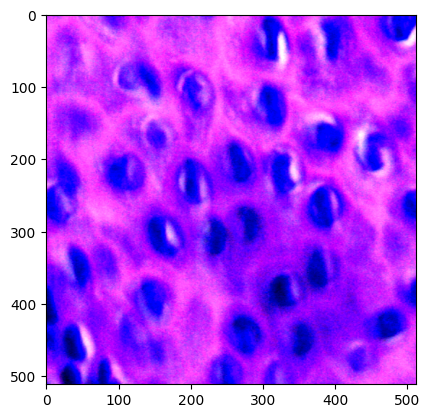

In [132]:
plt.imshow((patch_dataset.train_dataset[0][0].permute(1, 2, 0)*255).cpu().numpy())

Configuring patches

In [98]:
patch_dataset._create_df_splits(patch_dataset.k_folds_dataset)

In [99]:
np.unique(patch_dataset._generate_k_folds()[0][1], return_counts=True) # train labels for the first fold

(array([0, 1, 2]), array([ 414,  725, 1250], dtype=int64))

In [20]:
np.unique(patch_dataset._generate_k_folds()[0][3], return_counts=True) # test labels for the first fold

(array([0, 1]), array([453, 164], dtype=int64))

In [21]:
np.unique(patch_dataset._generate_k_folds()[1][1], return_counts=True) # train labels for the second fold

(array([0, 1]), array([1691,  725], dtype=int64))

In [22]:
np.unique(patch_dataset._generate_k_folds()[1][3], return_counts=True) # test labels for the second fold

(array([0, 1]), array([505, 112], dtype=int64))

In [23]:
patch_dataset.folds_df

,fold,image_path,class
0,0,000.000.006-15_23b9853b-a2df-5c02-874a-a0adcb1...,1
1,0,000.000.006-15_23b9853b-a2df-5c02-874a-a0adcb1...,1
2,0,000.000.006-15_23b9853b-a2df-5c02-874a-a0adcb1...,1
3,0,000.000.006-15_23b9853b-a2df-5c02-874a-a0adcb1...,1
4,0,000.000.006-15_23b9853b-a2df-5c02-874a-a0adcb1...,1
...,...,...,...
3028,4,000.000.312-16_114c48f4-2926-a02e-f265-bcf83bc...,0
3029,4,000.000.312-16_114c48f4-2926-a02e-f265-bcf83bc...,0
3030,4,000.000.312-16_114c48f4-2926-a02e-f265-bcf83bc...,0
3031,4,000.000.312-16_114c48f4-2926-a02e-f265-bcf83bc...,0


In [24]:
df = patch_dataset.folds_df

In [25]:
df['image_path'] = df['image_path'].apply(lambda x: "".join(x.split("_")[0:-1]))

In [26]:
df = df[['image_path', 'fold']]

In [27]:
df = df.drop_duplicates().reset_index(drop=True)

In [28]:
df

,image_path,fold
0,000.000.006-1523b9853b-a2df-5c02-874a-a0adcb1d...,0
1,000.000.006-15a396ae24-6d39-92ff-56c6-0a439c56...,0
2,000.000.006-15b5ff51ab-c0db-5517-4577-8f0cddaa...,0
3,000.000.006-15d3d213fc-36a4-10c4-657c-61363626...,0
4,000.000.007-1382e25fa2-7acb-22d5-cc9d-9fc9b519...,0
...,...,...
199,000.000.196-1611586011-d6a6-f87d-7f79-67c9dca4...,4
200,000.000.212-15ef1b0a89-b84f-2be2-6ee5-83c790be...,4
201,000.000.237-16d6bda184-494c-e411-150f-6296f6fe...,4
202,000.000.284-17afda088b-2645-88eb-89c5-e79a4ab7...,4


In [29]:
images_count = df['image_path'].value_counts()

In [30]:
images_count[images_count > 1]

Series([], Name: count, dtype: int64)

In [220]:
patch_dataset.folds_df.to_csv('folds.csv', index=False)

In [202]:
print("Folds lengths")
for i in range(5):
    print(f"Fold {i}: train {len(patch_dataset._generate_k_folds()[i][0])}, test {len(patch_dataset._generate_k_folds()[i][2])}")
    
    # get the labels count
    train_labels = np.unique(patch_dataset._generate_k_folds()[i][1], return_counts=True)
    test_labels = np.unique(patch_dataset._generate_k_folds()[i][3], return_counts=True)
    print(f"Train labels: {train_labels[0]}, {train_labels[1] / len(patch_dataset._generate_k_folds()[i][1]) * 100}%")
    print(f"Test labels: {test_labels[0]}, {test_labels[1] / len(patch_dataset._generate_k_folds()[i][1]) * 100}%\n")

mean = np.mean([len(patch_dataset._generate_k_folds()[i][0]) for i in range(5)])
print(f"Mean train length: {mean}")

std = np.std([len(patch_dataset._generate_k_folds()[i][0]) for i in range(5)])
print(f"Std train length: {std}")

Folds lengths
Fold 0: train 2456, test 564
Train labels: [0 1], [65.51302932 34.48697068]%
Test labels: [0 1], [18.52605863  4.43811075]%

Fold 1: train 2435, test 585
Train labels: [0 1], [68.99383984 31.00616016]%
Test labels: [0 1], [15.77002053  8.25462012]%

Fold 2: train 2380, test 640
Train labels: [0 1], [71.97478992 28.02521008]%
Test labels: [0 1], [14.74789916 12.14285714]%

Fold 3: train 2358, test 662
Train labels: [0 1], [66.45462256 33.54537744]%
Test labels: [0 1], [21.07718405  6.99745547]%

Fold 4: train 2451, test 569
Train labels: [0 1], [68.82904937 31.17095063]%
Test labels: [0 1], [15.38147695  7.83353733]%

Mean train length: 2416.0
Std train length: 39.61312913668901


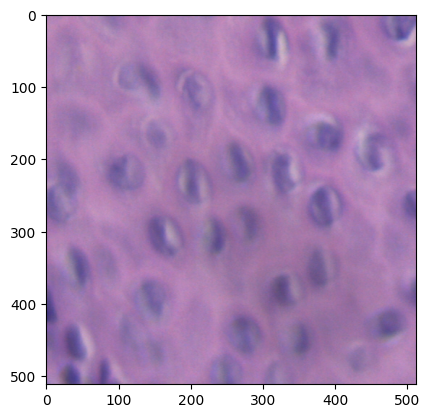

In [61]:
plt.imshow(patch_dataset.get_k_fold_train_val_tuple(0)[0][0][0].permute(1, 2, 0))

## Images dataset

The problem was reduced, therefore this is not used.

In [304]:
class ImageDataset:
    def __init__(self, images_path, metadata_path, train_size=0.8, transform=None):
        self.images_path = images_path
        self.metadata_path = metadata_path
        self.transform = transform if transform is not None else v2.Compose([v2.ToImage()])
        self.train_size = train_size
        self.train, self.test = self._train_test_split()

        self.train_dataset = CustomDataset(self.train[0], self.train[1], transform=self.transform)
        self.test_dataset = CustomDataset(self.test[0], self.test[1], transform=self.transform)

    def _get_files(self):
        """
        Get files from the path by class carcinoma and non-carcinoma
        """
        images = list(self.images_path.glob('*.png'))
        return images
    
    def _train_test_split(self):
        """
        Split the dataset into train and test
        """
        images = self._get_files()
        metadata= pd.read_csv(self.metadata_path)[["path", "diagnosis"]]

        classes = {"OSCC": "carcinoma", "Leukoplakia with dysplasia": "noncarcinoma", "Leukoplakia without dysplasia": "noncarcinoma"}
        metadata["diagnosis"] = metadata["diagnosis"].map(classes)

        # split into train and test
        train, test = train_test_split(metadata, train_size=self.train_size, stratify=metadata["diagnosis"], random_state=42)

        train_images = [image for image in images if image.parts[-1] in train["path"].values]
        test_images = [image for image in images if image.parts[-1] in test["path"].values]

        train_labels = [1 if 'carcinoma' == diagnosis else 0 for diagnosis in train["diagnosis"].values]
        test_labels = [1 if 'carcinoma' == diagnosis else 0 for diagnosis in test["diagnosis"].values]


        return (train_images, train_labels), (test_images, test_labels)



In [305]:
IMAGE_PATH = pl.Path(os.path.abspath("")) / pl.Path('../data') / pl.Path('images') 
METADATA_PATH = pl.Path(os.path.abspath("")) / pl.Path('../data') / pl.Path('ndb-ufes.csv') 

In [306]:
image_dataset = ImageDataset(IMAGE_PATH, METADATA_PATH)

In [307]:
train, test = image_dataset._train_test_split()

In [308]:
np.unique(train[1], return_counts=True)

(array([0, 1]), array([116,  73], dtype=int64))

In [309]:
np.unique(test[1], return_counts=True)

(array([0, 1]), array([30, 18], dtype=int64))

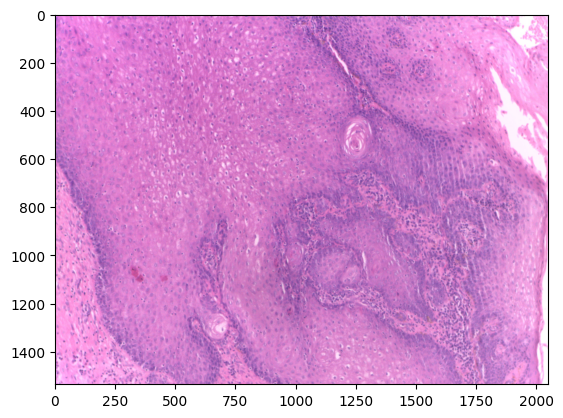

In [310]:
plt.imshow(image_dataset.train_dataset[0][0].permute(1, 2, 0))